# Indirect field oriented control system

In {cite}`Salas@2008,Bazanella@2000` the following model is considered

```{math}
:label: eq:IFOC
\begin{cases}
\begin{aligned}
\dot x_1 &= -c_1 x_1 + c_2 x_4 - \frac{k c_1}{u_2^0} x_2 x_4, \\
\dot x_2 &= -c_1 x_2 + c_2 u_2^0 + \frac{k c_1}{u_2^0} x_1 x_4, \\
\dot x_3 &= -c_3 x_3 - c_4 c_5 (x_2x_4 - u_2^0 x_1) + (c_4 T_m + c_3 w_{ref}), \\
\dot x_4 &= -(k_i-k_p)x_3 - k_p c_4 c_5 ( x_2 x_4 - u_2^0 x_1) + k_p (c_4 T_m + c_3 w_{ref}).
\end{aligned}
\end{cases}
```

Here $x_1 , x_2 , x_3$ and $x_4$ are the state variables, where $x_1$ and $x_2$
represent, respectively, direct and quadrature components of the rotor ﬂux;
$x_3$ is the rotor speed error; and $x_4$ denotes the quadrature axis component
of the stator current, respectively.  We also deﬁne the following constants and
parameters: $u_2^0$ is a constant reference for the rotor ﬂux magnitude; $c_1$
to $c_5$ are machine parameters; $k_p$ and $k_i$ are the proportional (P) and
the integral (I) control gains, respectively; $w_{ref}$ is the speed reference;
$T_m$ the load torque; $k$ the measure of rotor time constant mismatches.

The parameters $c_1,c_2,c_3,c_4,c_5,u_{20},k_p,k_i$ and $w_{ref}$ are fixed as
follows

$$
\begin{aligned}
c_1 &= 4.4868, \\
c_2 &= 0.3567, \\
c_3 &= 0, \\
c_4 &= 9.743, \\
c_5 &= 1.911, \\
u_2^0 &= 11.3, \\
k_p &= 4.5, \\
k_i &= 500, \\
w_{ref} &= 0, \\
\end{aligned}
$$
while the parameters $k$ and $T_m$ are used as unfolding parameters.

## Overview

In this demo we will

- Define an analytically derived Bogdanov-Takens point.
- Start continuation of the homoclinic branch emanating from the
  Bogdanov-Takens points in two parameters $(k,T_m)$ using the new homoclinic
  smooth orbital predictor from {cite}`Bosschaert@2021`.
- Compare the predicted and computed homoclinic bifurcation curve emanating from the
  Bogdanov-Takens point in parameters space.
- Compare a range of predictors for the homoclinic solutions emanating from the
  Bogdanov-Takens point with the corrected homoclinic solutions curve in
  phase-space.
- Create a convergence plot of the different homoclinic approximations
  derived in {cite}`Bosschaert@2021`.

## Load MatCont

Before we can start using __MatCont__ we need to add the main directory of
__MatCont,__ as well as various subdirectories of __MatCont,__ to the _MATLAB
search path_. This is done in the code below. The variable `matcont_home`
should point to the main directory of __MatCont.__

In [1]:
clear all
matcontpath = '../';
addpath(matcontpath)
addpath([matcontpath, 'Equilibrium'])
addpath([matcontpath, 'Systems'])
addpath([matcontpath, 'Hopf'])
addpath([matcontpath, 'Homoclinic'])
addpath([matcontpath, 'LimitPoint'])
addpath([matcontpath, 'LimitCycle'])
addpath([matcontpath, 'Continuer'])
addpath([matcontpath, 'MultilinearForms'])
addpath([matcontpath, 'Utilities'])
set(groot, 'defaultTextInterpreter', 'LaTeX');
set(0,'defaultAxesFontSize',15)

## Set the odefile

Next we set the variable `odefile` to the _system file_ previously generated by
the notebook [IFOCGenSym.ipynb](./IFOCGenSym.ipynb).

In [2]:
odefile=@IFOC;

## Define Bogdanov-Takens point manually

Since $w_{ref}$ vanishes the equilibria of {eq}`eq:IFOC` are invariant under
the transformation

```{math}
:label: eq:symmetry
(x_1, x_2, x_3, x_4, T_m) \mapsto (-x_1, x_2, -x_3, -x_4, -T_m).
```

Then solving simultaneously for equilibria of {eq}`eq:IFOC` with vanishing
determinant of the Jacobian with respect to the variables $x_1, x_2, x_3$ 
and $x_4$, and the unfolding parameter $T_m$ yields four solutions. Two solutions are
given by

$$
\begin{aligned}
x_1^{\pm} &= \frac{c_2 \left(k^2 \pm \sqrt{k^4-10 k^2+9}-1\right)
|u_{20}|\sqrt{k^2 \mp \sqrt{k^4-10 k^2+9}-3}}{4 \sqrt{2} c_1 (k+1)|k|}, \\
x_2^{\pm} &= \frac{c_2 \left(\pm\sqrt{k^4-10 k^2+9}+k (k+4)+3\right) u_{20}}{4 c_1 k (k+1)}, \\
x_3 &= 0, \\
x_4^{\mp} &= -\frac{|u_{20}|\sqrt{\left(k^2\mp\sqrt{k^4-10 k^2+9}-3\right) }}{\sqrt{2}|k|}, \\
T_m^{\pm} &= -\frac{c_2 c_5 \left(k^2 \pm \sqrt{k^4-10 k^2+9}+3\right) u_{20} 
|u_{20}|\sqrt{k^2 \mp \sqrt{k^4-10 k^2+9}-3}}{4 \sqrt{2} c_1 k|k|},
\end{aligned}
$$
while the second two follow from the symmetry {eq}`eq:symmetry`.

Next we solve for a double zero of the characteristic equation of the Jacobian
with respect to the unfolding parameter $k$. This reveals that there are two
solutions given by

$$
(\pm x_1^-, x_2^-, 0, \pm x_4^+, \pm T_m^-),
$$

with

$$
k = 1+\frac{1}{3} \sqrt[3]{216-24 \sqrt{57}}+\frac{2 \sqrt[3]{9+\sqrt{57}}}{3^{2/3}}.
$$

Thus we can explicitly define the Bogdanov-Takens point

In [3]:
c1 = 4.4868;
c2 = 0.3567;
c5 = 1.911;
u20 = 11.3;
k = 1+(1/3)*(216+(-24)*57^(1/2))^(1/3)+2*3^(-2/3)*(9+57^(1/2))^(1/3);
x1m = (1/4)*2^(-1/2)*c1^(-1)*c2*(1+k)^(-1)*((-1)+k^2+(-1)*(9+( ...
      -10)*k^2+k^4)^(1/2))*(k^(-2)*((-3)+k^2+(9+(-10)*k^2+ ...
      k^4)^(1/2))*u20^2)^(1/2);
x2m = (1/4)*c1^(-1)*c2*k^(-1)*(1+k)^(-1)*(3+k*(4+k)+(-1)*(9+( ...
      -10)*k^2+k^4)^(1/2))*u20;
x3 = 0;
x4p = (-1)*2^(-1/2)*(k^(-2)*((-3)+k^2+(9+(-10)*k^2+k^4)^(1/2))*u20^2)^(1/2);
Tmm = (-1/4)*2^(-1/2)*c1^(-1)*c2*c5*k^(-1)*(3+k^2+(-1)*(9+( ...
      -10)*k^2+k^4)^(1/2))*u20*(k^(-2)*((-3)+k^2+(9+(-10)* ...
      k^2+k^4)^(1/2))*u20^2)^(1/2);
bt1.x = [x1m; x2m; x3; x4p];
bt1.par = [k; Tmm];

To refer to the parameters throughout the script we create a __cell array__ of
strings containing the parameter names. This is then converted into a
__struct__. This allows us to refer to the parameters as `ind.parametername`,
similar as done in _DDE-BifTool_.

In [4]:
parnames = {'k', 'Tm'};
cind = [parnames;num2cell(1:length(parnames))];
ind  = struct(cind{:});

## Continue homoclinic curve emanating from the Bogdanov-Takens point

To continue the homoclinic curve emanating from the Bogdanov-Takens point we
use the functions `BT_Hom_set_options` and `init_BT_Hom` to obtain an initial
approximation to the homoclinic solution (`hom_x`) as well as a tangent vector
to the discretized homoclinic solution (`hom_v`) as described in
{ref}`initial-prediction-Homoclinic-orbit`. 

In [5]:
ap = [ind.k, ind.Tm];
BToptions = BT_Hom_set_options();
[hom_x, hom_v] = init_BT_Hom(odefile, bt1,  ap, BToptions);
opt = contset;
opt.Singularities = 0;
opt.MaxNumPoints = 900;
homoclinic_br1 = cont(@homoclinic, hom_x, hom_v, opt);

BT normal form coefficients:
a=-2.800604e+01,	 b=9.109991e-01
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 2.02473
The initial half-return time T: 1.17262
The initial distance time eps0: 0.0149101
The initial distance time eps1: 0.00705633
first point found
tangent vector to first point found

elapsed time  = 82.1 secs
npoints curve = 900


We see that the initial amplitude is large compared to the previously
considered models. Nonetheless the homoclinic approximation converges and the
homoclinic solution is continued correctly.

## Compare predicted with computed parameters

Now that we have obtained a curve of homoclinic orbits (`homoclinic_br`) we
compare the computed curve in parameter space with the predicted curve we
construct below. To do so, we use the function `BT_nmfm_orbital` to obtain the
smooth orbital normal form coefficients, i.e. $a$ and $b$, and the coefficients
of the transformation $K$ between the parameters of the system and the parameters
of the smooth orbital normal form on the center manifold, see
{cite}`Bosschaert@2021`.

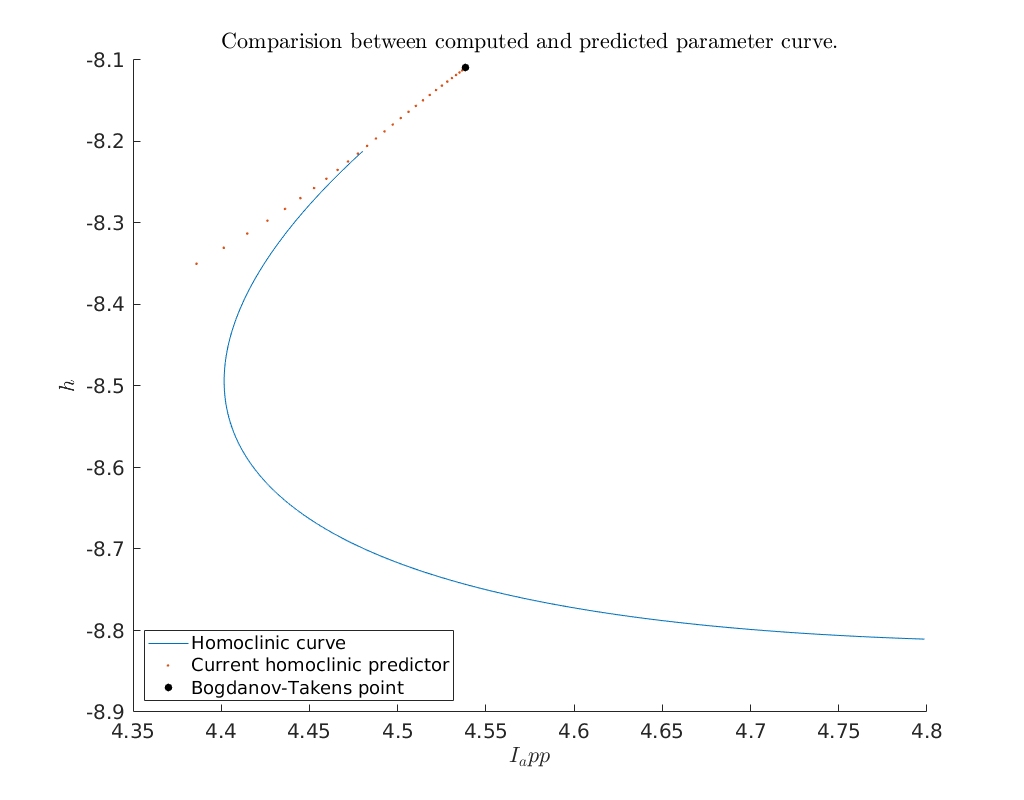

In [6]:
%plot --width 1024 --height 800
hold on
global homds
% plot computed parameter curve
plot(homoclinic_br1(homds.PeriodIdx+1,:), ...
     homoclinic_br1(homds.PeriodIdx+2,:));
% Bogdanov-Takens parameter-dependent normal form coefficients
bt1 = BT_nmfm_orbital(odefile, bt1, ap, BToptions);
a   = bt1.nmfm.a;
b   = bt1.nmfm.b;
K10 = bt1.nmfm.K10;
K01 = bt1.nmfm.K01;
K02 = bt1.nmfm.K02;
K11 = bt1.nmfm.K11;
K03 = bt1.nmfm.K03;
% construct predictor as in the paper
eps = linspace(0, 0.15, 30);
beta1 = -4*a^3/b^4*eps.^4;
tau0  = 10/7;
tau2  = 288/2401;
beta2 = a/b*(tau0 + tau2*eps.^2).*eps.^2;
alpha = K10.*beta1 + K01.*beta2 + 1/2*K02.*beta2.^2 ...
    + K11.*beta1.*beta2 + 1/6*K03.*beta2.^3;
alpha = bt1.par(ap) + alpha;
% plot currect predictor
plot(alpha(1,:), alpha(2,:), '.')
% plot Bogdanov-Takens point
plot(bt1.par(ind.k), bt1.par(ind.Tm), '.k', 'MarkerSize', 20)
% set axis labels and legend
xlabel('$I_app$')
ylabel('$h$')
legend({'Homoclinic curve', 'Current homoclinic predictor', ...
    'Bogdanov-Takens point'}, 'Location', 'SouthWest')
title('Comparision between computed and predicted parameter curve.')

If we would like to have the homoclinic curve close to the Bogdanov-Takens
point we could start the continuation of the homoclinic orbit with a smaller
amplitude, for example with `BToptions.amplitude = 0.1`. Another possibility is
to continue the homoclinic curve in the reverse direction. Here we choose the
second approach.

In [7]:
[hom_x, hom_v] = init_BT_Hom(odefile, bt1,  ap, BToptions);
opt.Singularities = 0;
opt.MaxNumPoints = 120;
opt.Backward = 1;
homoclinic_br1_rev = cont(@homoclinic, hom_x, hom_v, opt);

BT normal form coefficients:
a=-2.800604e+01,	 b=9.109991e-01
The initial perturbation parameter epsilon:  1.000000e-01
The initial amplitude: 2.02473
The initial half-return time T: 1.17262
The initial distance time eps0: 0.0149101
The initial distance time eps1: 0.00705633
first point found
tangent vector to first point found
Current step size too small (point 97)
elapsed time  = 9.9 secs
npoints curve = 97


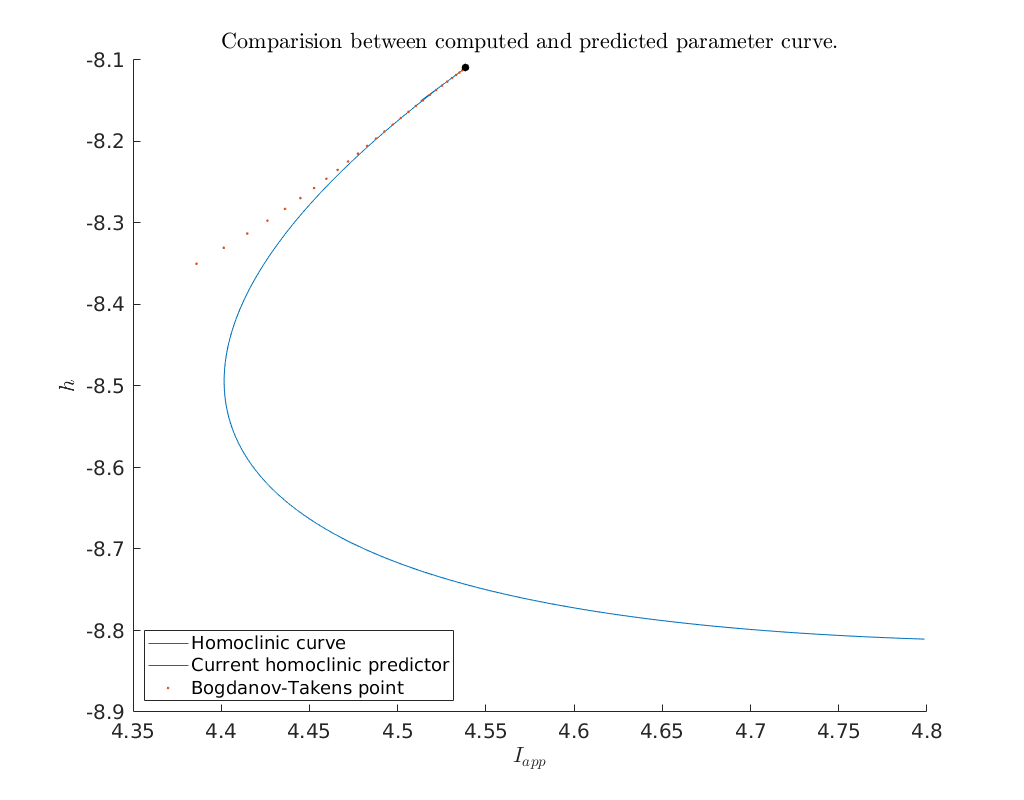

In [12]:
%plot --width 1024 --height 800
hold on
cm = lines();
homColor  = cm(1,:);
% plot computed parameter curve
plot(homoclinic_br1(homds.PeriodIdx+1,:), ...
     homoclinic_br1(homds.PeriodIdx+2,:), ...
     'Color', homColor);
plot(homoclinic_br1_rev(homds.PeriodIdx+1,:), ...
     homoclinic_br1_rev(homds.PeriodIdx+2,:), ...
     'Color', homColor);
% plot currect predictor
plot(alpha(1,:), alpha(2,:), '.', 'Color', cm(2,:))
% plot Bogdanov-Takens point
plot(bt1.par(ind.k), bt1.par(ind.Tm), '.k', 'MarkerSize', 20)
% set axis labels and legend
xlabel('$I_{app}$')
ylabel('$h$')
legend({'Homoclinic curve', 'Current homoclinic predictor', ...
    'Bogdanov-Takens point'}, 'Location', 'SouthWest')
title('Comparision between computed and predicted parameter curve.')

## Plot of continued homoclinic solutions in $(x_1,x_2,x_3)$ phase-space

To obtain an impression of the  homoclinic solutions we plot the computed
homoclinic orbits in $(x_1,x_2,x_3)$ phase-space.


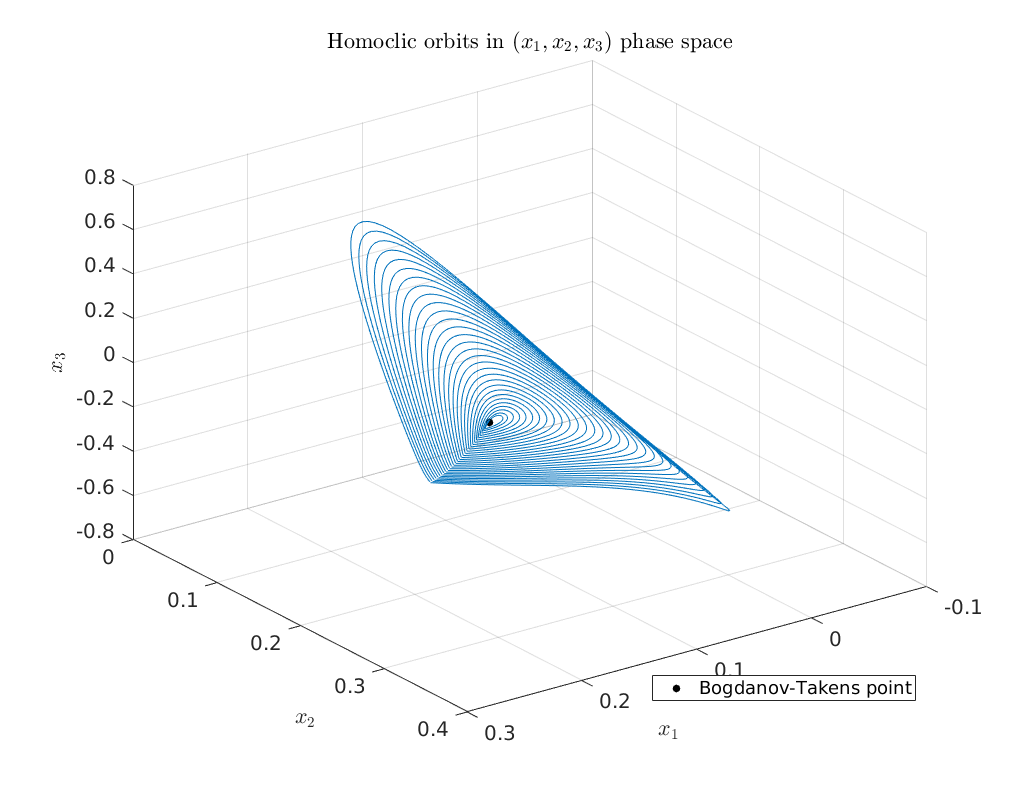

In [9]:
hold on
plot3(homoclinic_br1(homds.coords(1:homds.nphase:end), 1:30:end), ...
      homoclinic_br1(homds.coords(2:homds.nphase:end), 1:30:end), ...
      homoclinic_br1(homds.coords(3:homds.nphase:end), 1:30:end), ...
     'Color', [0 0.4470 0.7410], 'HandleVisibility', 'Off')
xlabel('$x_1$')
ylabel('$x_2$')
zlabel('$x_3$')
plot3(bt1.x(1), bt1.x(2), bt1.x(3), '.k' ,'MarkerSize', 20)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(x_1,x_2,x_3)$ phase space')
grid on
view([144, 31]);

### Predictors of orbits for various epsilons

Below we compute for a large range of amplitudes the predicted and corrected
homoclinic solutions and compare them in phase space. We see that even with an
amplitude of `1` the predicted homoclinic orbit is still very close.

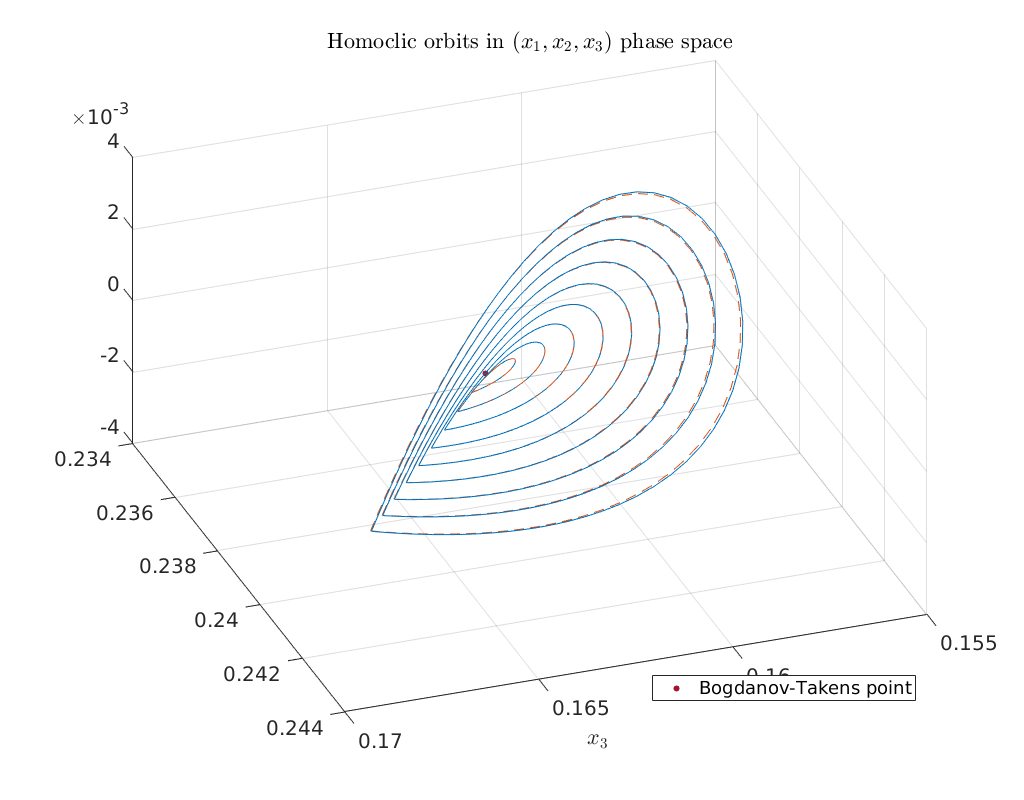

In [10]:
options = BT_Hom_set_options();
options.messages = false;
options.correct = false;
options.TTolerance = 1.0e-05;

amplitudes = linspace(1.0e-03, 1, 10);
XPredicted = zeros(660,length(amplitudes));
XCorrected = zeros(660,length(amplitudes));
for j=1:length(amplitudes)
  options.amplitude = amplitudes(j);
  [x_pred, v0] = init_BT_Hom(odefile, bt1, ap, options);
  XPredicted(:,j) = x_pred;
  try
    XCorrected(:,j) = newtcorr(x_pred, v0);
  catch
    warning('Didn''t convergence to homoclinic solution')
  end
end

hold on
cm = lines;
plot3(XPredicted(homds.coords(1:homds.nphase:end),1:10), ...
      XPredicted(homds.coords(2:homds.nphase:end),1:10), ...
      XPredicted(homds.coords(3:homds.nphase:end),1:10), ...
      'color', cm(1,:), 'HandleVisibility', 'Off')
plot3(XCorrected(homds.coords(1:homds.nphase:end),1:10), ...
      XCorrected(homds.coords(2:homds.nphase:end),1:10), ...
      XCorrected(homds.coords(3:homds.nphase:end),1:10), ...
      '--', 'color', cm(2,:), 'HandleVisibility', 'Off')
plot3(bt1.x(1), bt1.x(2), bt1.x(3), '.', 'MarkerSize', 16)
legend('Bogdanov-Takens point', 'Location', 'SouthEast')
title('Homoclic orbits in $(x_1,x_2,x_3)$ phase space')
xlabel('$x_1$')
xlabel('$x_2$')
xlabel('$x_3$')
grid on
view([160, 45]);

## Convergence plot

We finish this notebook with a log-log convergence plot comparing the different
third order homoclinic approximation methods derived in {cite}`Bosschaert@2021`
to approximate the homoclinic solutions near the first Bogdanov-Takens point.
On the abscissa is the amplitude $A_0$ and on the ordinate the relative error
$\delta$ between the constructed solution (`x_pred`) to the defining system for the
homoclinic orbit and the Newton corrected solution (`x_corrected`).

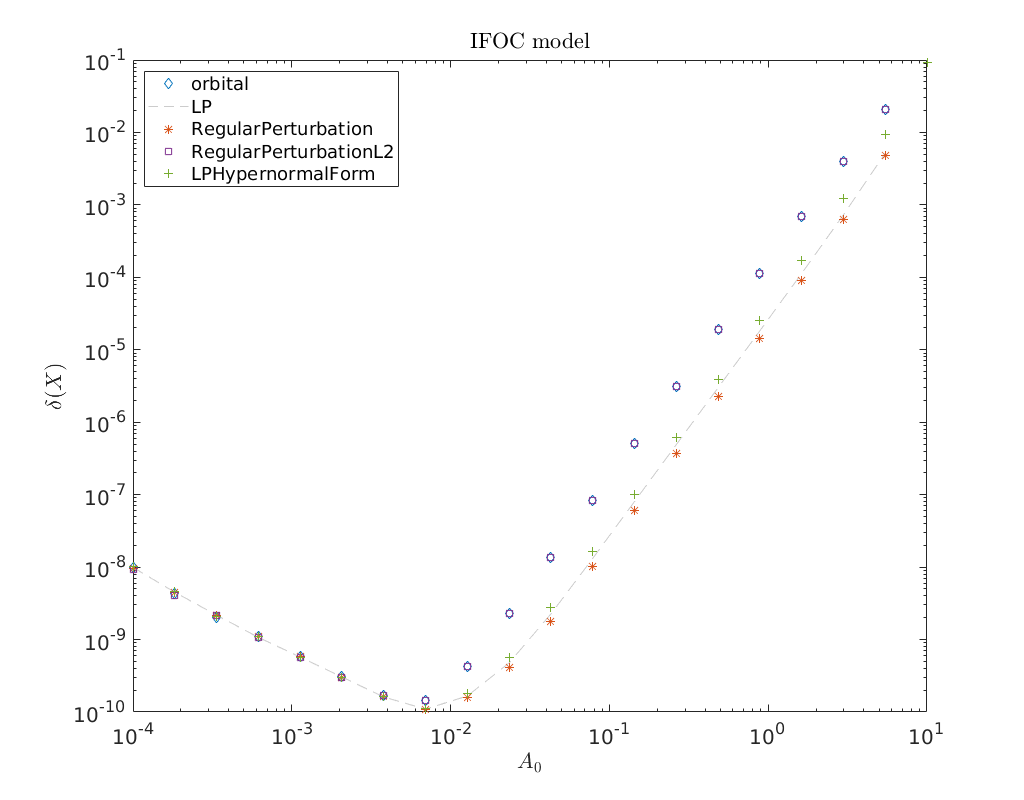

In [11]:
BToptions = BT_Hom_set_options();
BToptions.TTolerance = 1e-05;
BToptions.messages = false;
BToptions.correct = false;

amplitudes = logspace(-4, 1, 20);
methodList = {'orbital', 'LP', 'RegularPerturbation', ...
    'RegularPerturbationL2', 'LPHypernormalForm'};
relativeErrors = {};
for i=1:length(methodList)
    BToptions.method = methodList{i};
    relativeErrors{i} = zeros(size(amplitudes));
    for j=1:length(amplitudes)
    BToptions.amplitude = amplitudes(j);
    [x_pred, v0] = init_BT_Hom(odefile, bt1, ap, BToptions);
    try
        x_corrected = newtcorr(x_pred, v0);
        relativeErrors{i}(j) = norm(x_corrected-x_pred)/norm(x_corrected);
    catch
        warning('Did not converge.')
        continue
    end
  end
end

cm = lines();
loglog(amplitudes, relativeErrors{1}(:), 'd', ...
       amplitudes, relativeErrors{2}(:), '--', ...
       amplitudes, relativeErrors{3}(:), '*', ...
       amplitudes, relativeErrors{4}(:), 's', ...
       amplitudes, relativeErrors{5}(:), '+')
legend(methodList, 'Location', 'NorthWest')
title('IFOC model')
xlabel('$A_0$')
ylabel('$\delta(X)$')
ax = gca;
ax.ColorOrder = [cm(1,:); [0.8 0.8 0.8]; cm(2,:); cm(4,:); cm(5,:)];